In [41]:
# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import SIRT as SIRT_CIL
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation \

# Import CIL Processors for preprocessing
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter

# Import CIL utilities
from cil.utilities.display import show2D
from cil.utilities import dataexample

# Import from CIL tigre plugin
from cil.plugins.tigre import ProjectionOperator
from cil.plugins.tigre import tigre_algo_wrapper

# Import FBP from CIL recon class
from cil.recon import FBP, FDK

from cil.framework import ImageData

#Import Total Variation from the regularisation toolkit plugin
from cil.plugins.ccpi_regularisation.functions import FGP_TV

# All external imports
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

New geometry:  2D Cone-beam tomography
System configuration:
	Source position: [     0., -20000.]
	Rotation axis position: [0., 0.]
	Detector position: [    0., 60000.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [128   1]
	Pixel size: [64. 64.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 60
	Angles 0-9 in degrees: [ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54.]
	Angles 50-59 in degrees: [300., 306., 312., 318., 324., 330., 336., 342., 348., 354.]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (60, 128)
New geometry shape:  (60, 128)
FDK recon

Input Data:
	angle: 60
	horizontal: 128

Reconstruction Volume:
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



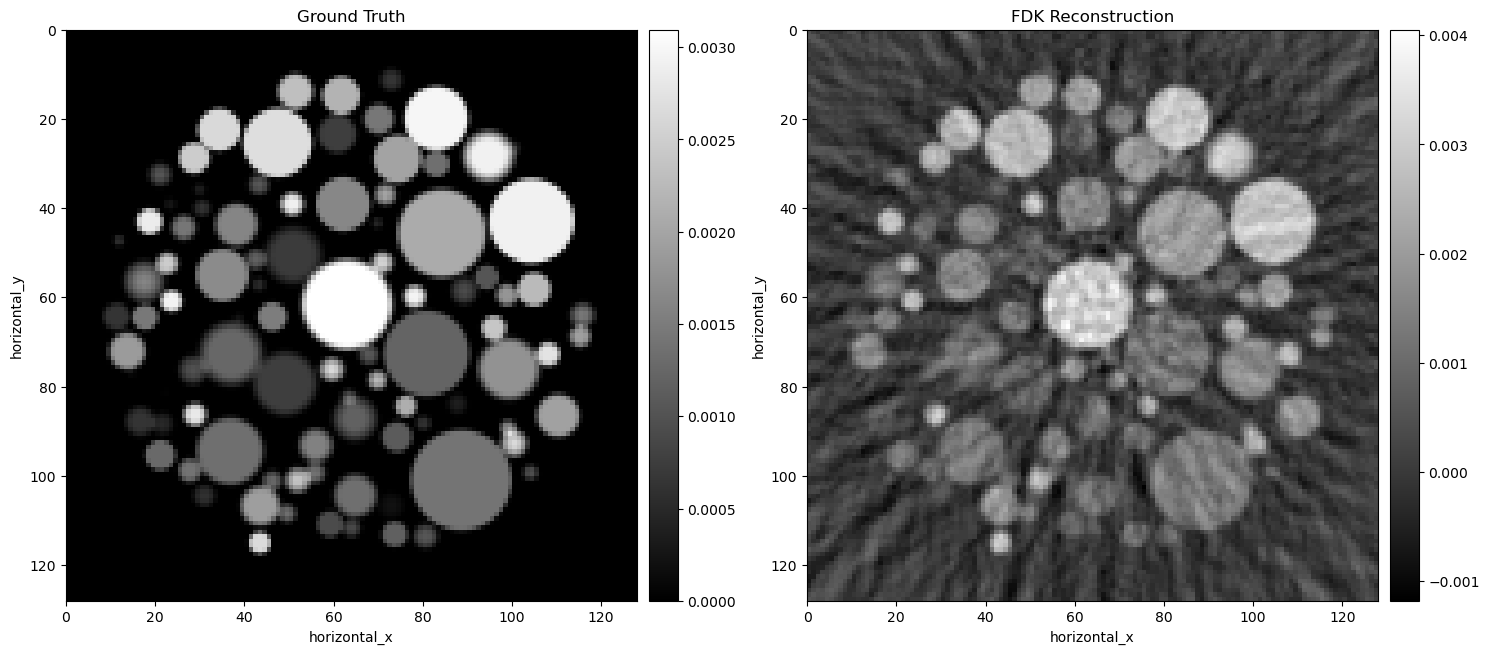

In [42]:
##fan beam data example

ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()

data = data.get_slice(vertical='centre')
ground_truth = ground_truth.get_slice(vertical='centre')

absorption = TransmissionAbsorptionConverter()(data)
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)

ig = ground_truth.geometry
ag= absorption.geometry

recon = FDK(absorption, image_geometry=ig).run()
show2D([ground_truth, recon], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);
A = ProjectionOperator(ig, absorption.geometry)




In [43]:
algo = tigre_algo_wrapper(name='sart', initial=None, image_geometry=ig, data=absorption, niter=5)
img, qual = algo.run()

SART algorithm in progress.
Estimated time until completion : 00:00:49


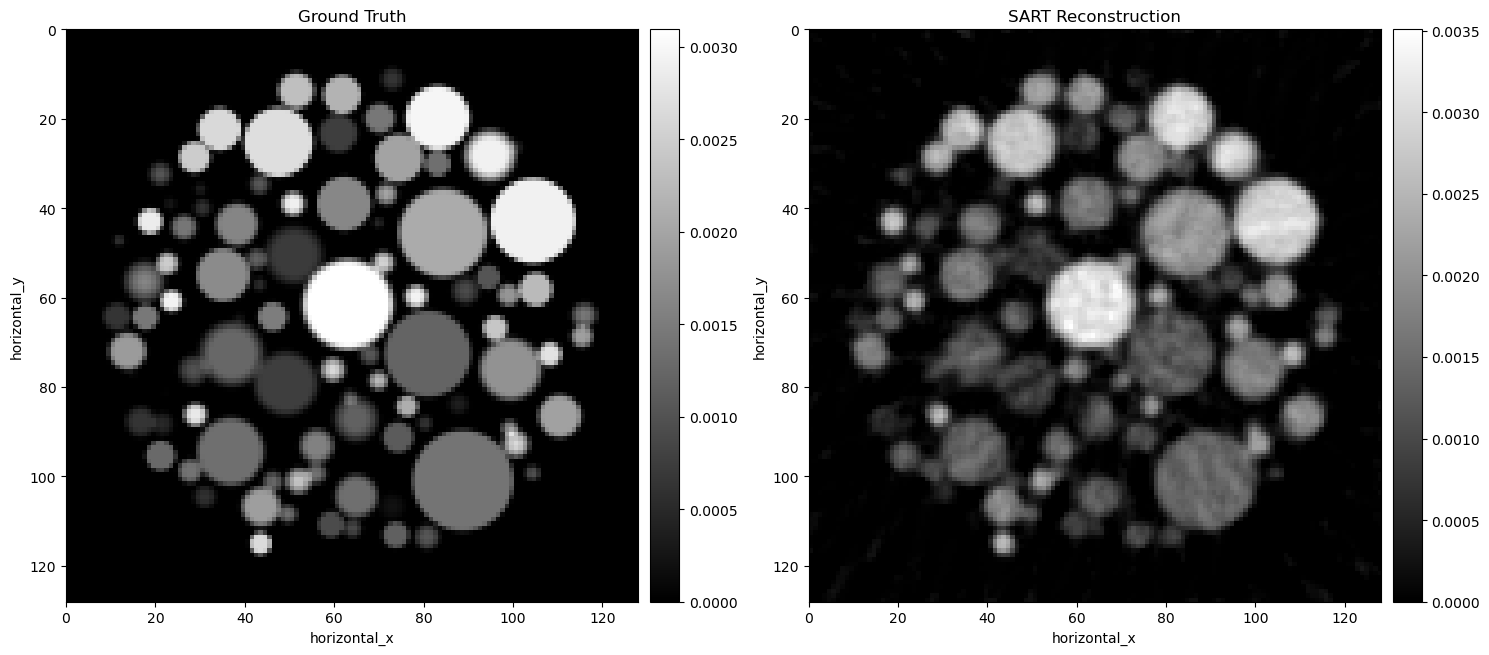

In [44]:
show2D([ground_truth, img], title = ['Ground Truth', 'SART Reconstruction'], origin = 'upper', num_cols = 2);

In [45]:
print('Quality of SART reconstruction: ', qual)

Quality of SART reconstruction:  None


CGLS algorithm in progress.
Estimated time until completion : 00:00:00
Average time taken for each iteration for CGLS:0.031813425663858655(s)


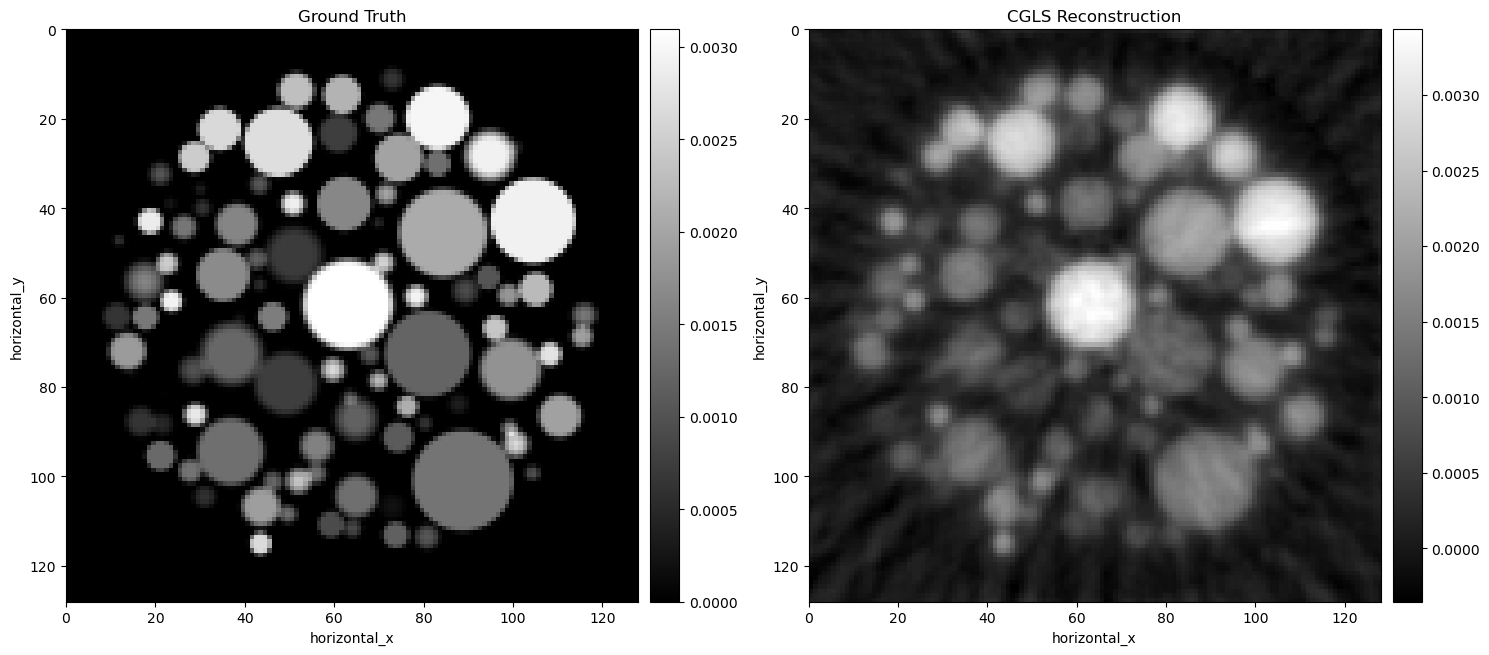

In [46]:
algo = tigre_algo_wrapper(name='cgls', initial=None, image_geometry=ig, data=absorption, niter=5)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'CGLS Reconstruction'], origin = 'upper', num_cols = 2);

LSMR algorithm in progress.
Estimated time until completion : 00:00:00


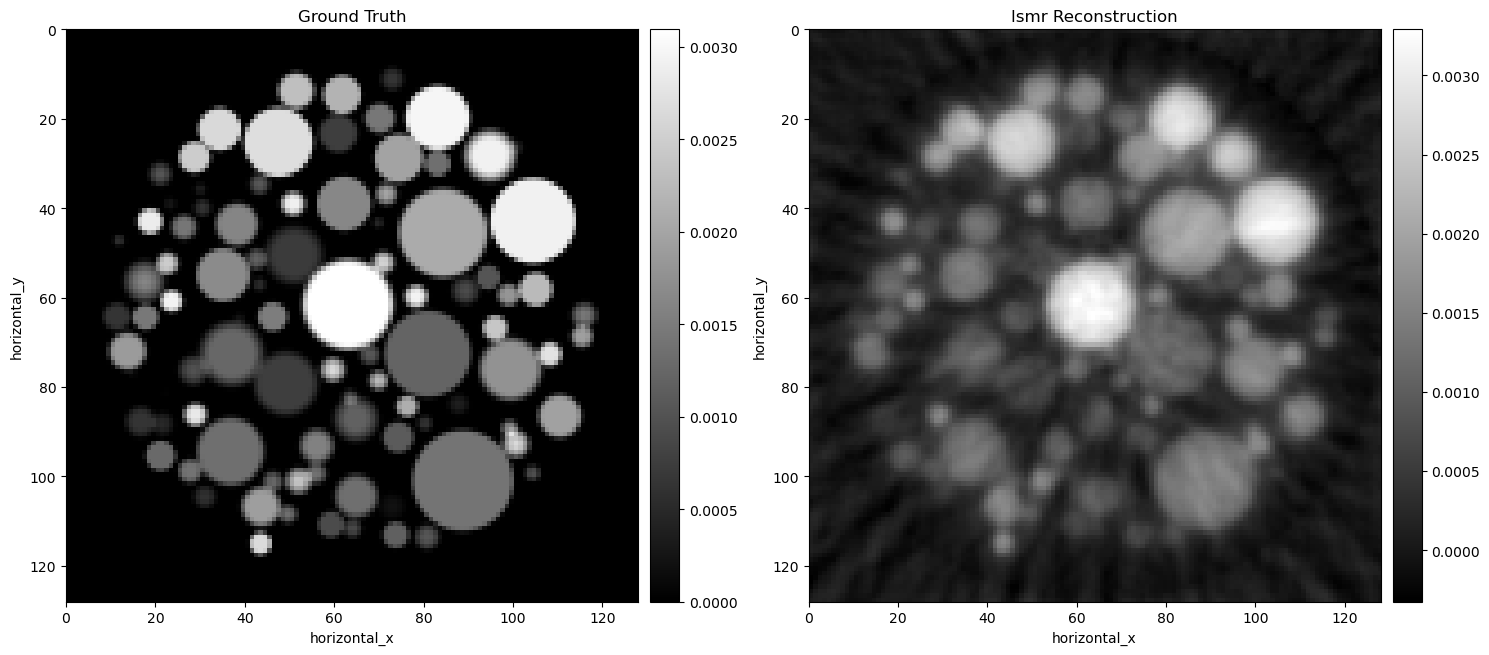

In [47]:
algo = tigre_algo_wrapper(name='lsmr', initial=None, image_geometry=ig, data=absorption, niter=5)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'lsmr Reconstruction'], origin = 'upper', num_cols = 2);

HYBRID_LSQR algorithm in progress.
Estimated time until completion : 00:00:00


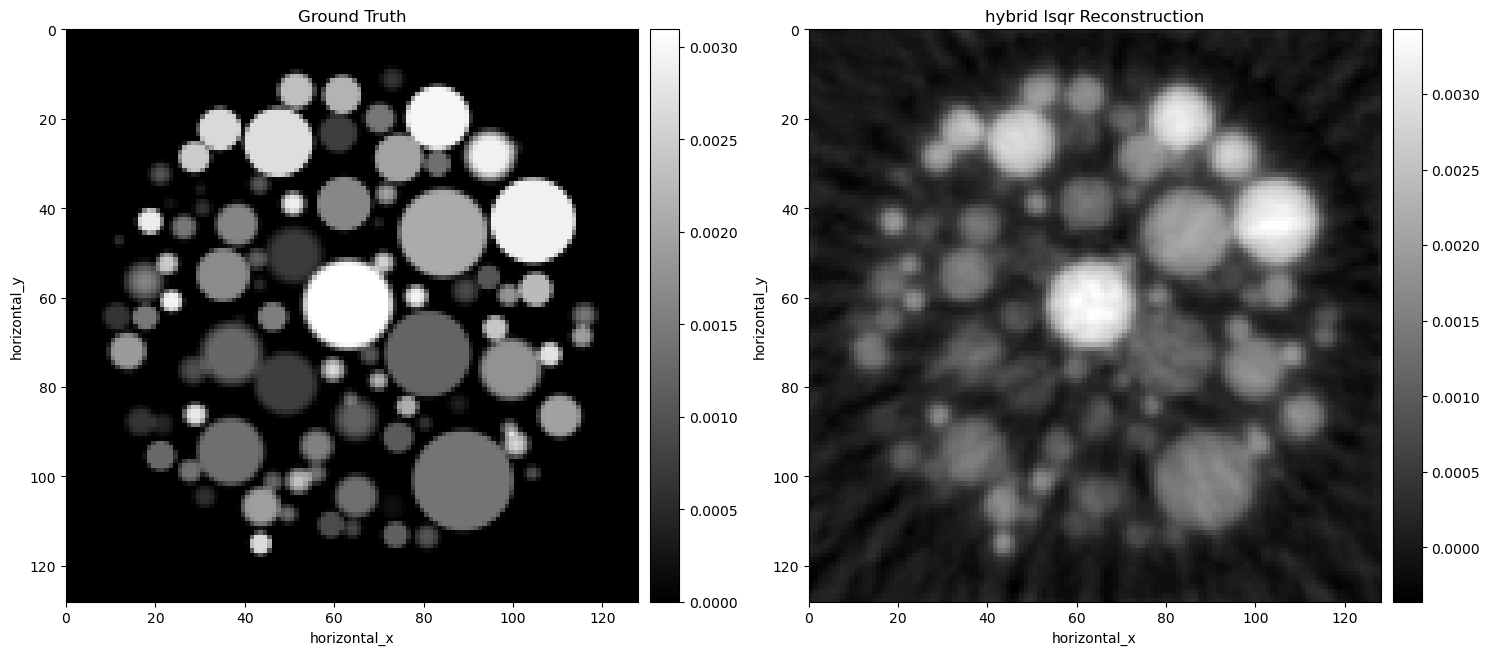

In [48]:
algo = tigre_algo_wrapper(name='hybrid_lsqr', initial=None, image_geometry=ig, data=absorption, niter=5)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'hybrid lsqr Reconstruction'], origin = 'upper', num_cols = 2);

Using GPU ids: {'name': '', 'devices': [0]}
{'name': '', 'devices': [0]}
ISTA algorithm in progress.
Estimated time until completion : 00:00:00


/tmp/ipykernel_1386615/15900395.py:5: UserWarning: We are aware that the TIGRE algorithms: ISTA, FISTA, SART_TV, OSSART_TV using 2D data can lead to incorrect results in the TV denoising step, particularly when using more than one GPU.
  algo = tigre_algo_wrapper(name='ista', initial=None, image_geometry=ig, data=absorption, niter=15, hyper=A.norm()**2, Quameasopts=['RMSE'], tvlambda=0.01, gpuids=gpuids)


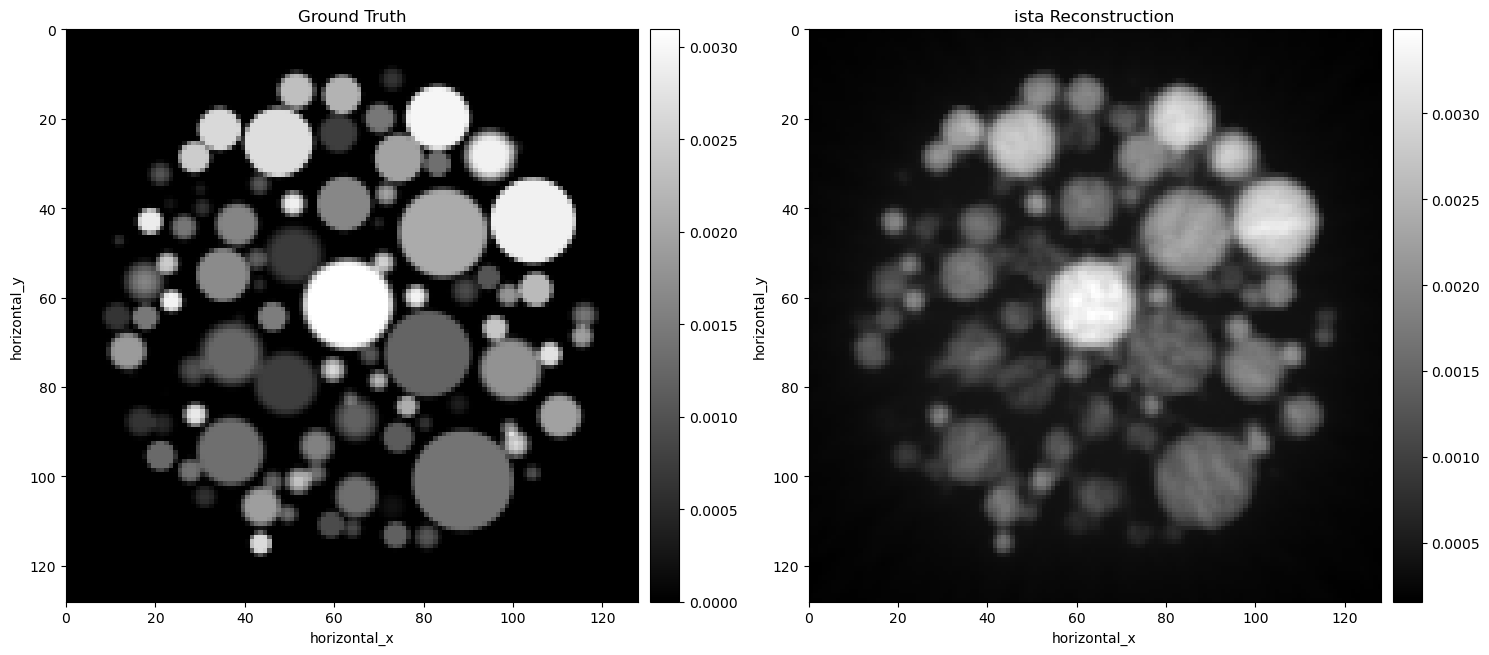

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [49]:
from tigre.utilities.gpu import GpuIds
gpuids = GpuIds()
gpuids.devices = [0]  # Specify the GPU device IDs you want to use
print("Using GPU ids:", gpuids)
algo = tigre_algo_wrapper(name='ista', initial=None, image_geometry=ig, data=absorption, niter=15, hyper=A.norm()**2, Quameasopts=['RMSE'], tvlambda=0.01, gpuids=gpuids)
print(algo.gpuids)  # Print the GPU ids used in the algorithm
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'ista Reconstruction'], origin = 'upper', num_cols = 2);
plt.figure()



(60, 1, 128) (1, 128, 128)


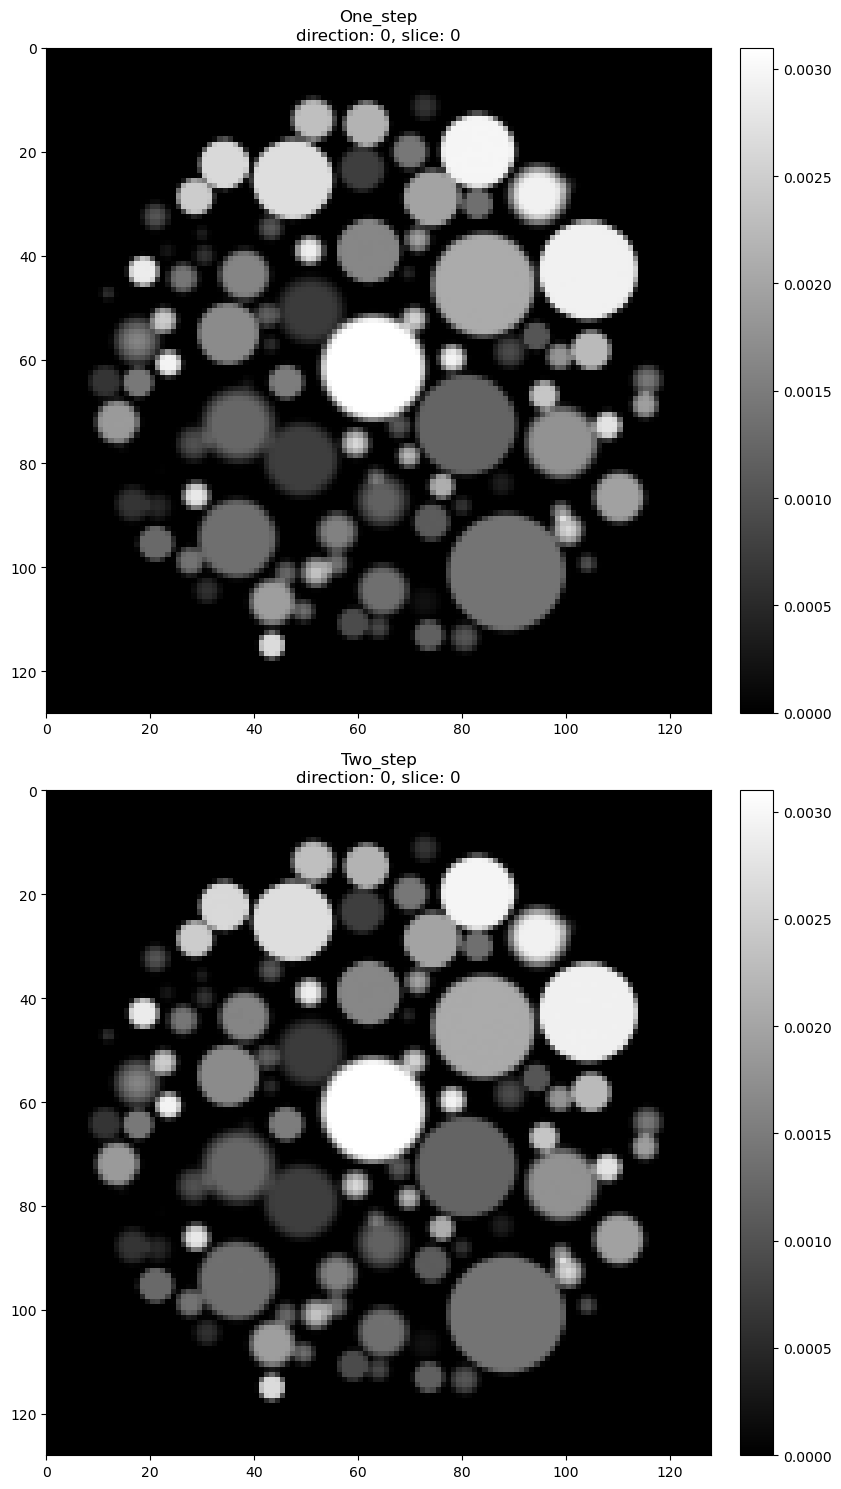

In [50]:
from tigre.utilities.Atb import Atb
from tigre.utilities.Ax import Ax
from cil.plugins.tigre import CIL2TIGREGeometry
from cil.framework.labels import AcquisitionDimension
import numpy as np
tigre_geom, tigre_angles = CIL2TIGREGeometry.getTIGREGeometry(
            ig, ag)
tigre_geom.check_geo(tigre_angles)
tigre_projections = absorption.as_array()
tigre_ground_truth = ground_truth.as_array()

if data.dimension_labels[0] != AcquisitionDimension.ANGLE:
    tigre_projections = np.expand_dims(tigre_projections, axis=0)

if tigre_geom.is2D:
    tigre_projections = np.expand_dims(tigre_projections, axis=1)
    tigre_ground_truth = np.expand_dims(ground_truth.as_array(), axis=0)

A = ProjectionOperator(ig, absorption.geometry)
step_size = 1/(2*A.norm()**2)
print(tigre_projections.shape, tigre_ground_truth.shape)
one_step = tigre_ground_truth - step_size*Atb(
                (
                    tigre_projections
                    - Ax(tigre_ground_truth, tigre_geom, tigre_angles, "interpolated", gpuids=gpuids)
                ),
                tigre_geom,
                tigre_angles,
                "matched",
                gpuids=gpuids,
            )

two_step = one_step - step_size*Atb(
                (
                    tigre_projections
                    - Ax(one_step, tigre_geom, tigre_angles, "interpolated", gpuids=gpuids)
                ),
                tigre_geom,
                tigre_angles,
                "matched",
                gpuids=gpuids,
            )


        

show2D([one_step, two_step], title = ["One_step", "Two_step"], origin = 'upper', num_cols = 1);

/tmp/ipykernel_1386615/2128816031.py:1: UserWarning: We are aware that the TIGRE algorithms: ISTA, FISTA, SART_TV, OSSART_TV using 2D data can lead to incorrect results in the TV denoising step, particularly when using more than one GPU.
  algo = tigre_algo_wrapper(name='fista', initial=None, image_geometry=ig, data=absorption, niter=5, hyper=2*A.norm()**2, Quameasopts=['RMSE'], tvlambda=0.001, gpuids=gpuids)


FISTA algorithm in progress.
Estimated time until completion : 00:00:00


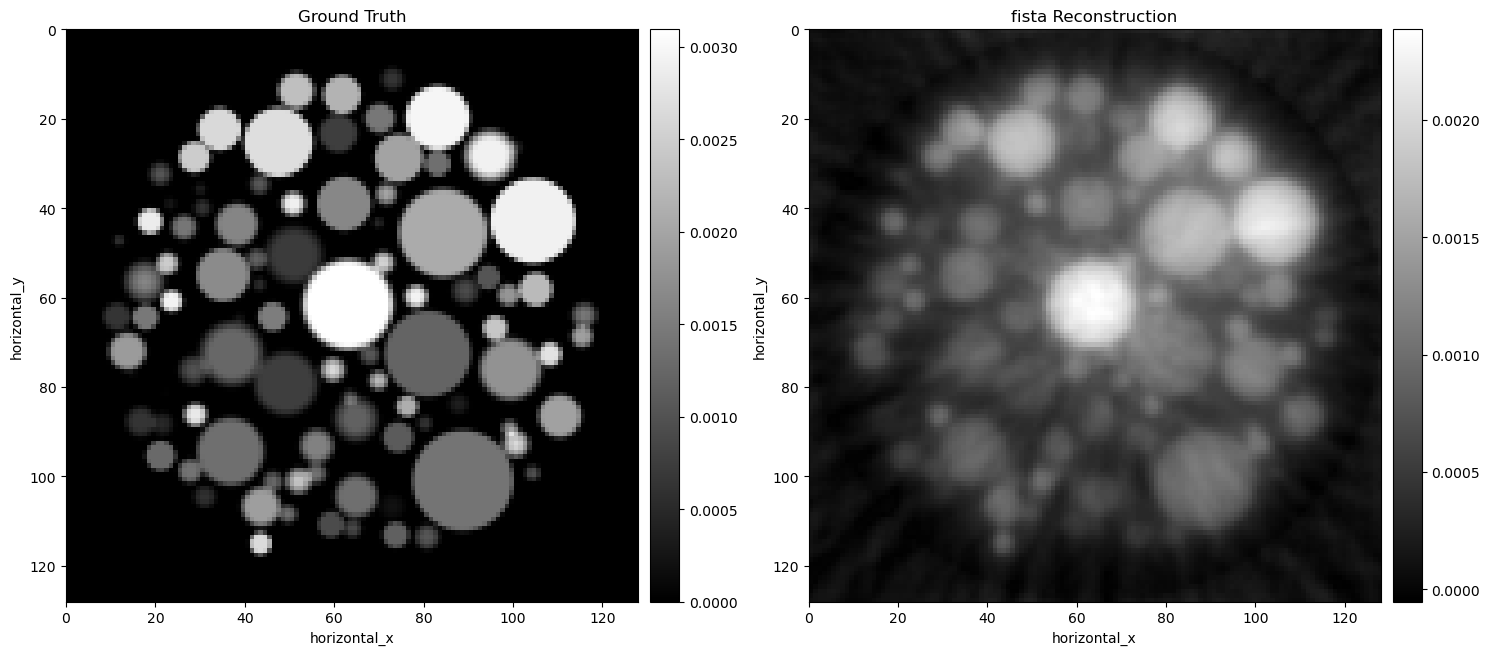

In [51]:
algo = tigre_algo_wrapper(name='fista', initial=None, image_geometry=ig, data=absorption, niter=5, hyper=2*A.norm()**2, Quameasopts=['RMSE'], tvlambda=0.001, gpuids=gpuids)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'fista Reconstruction'], origin = 'upper', num_cols = 2);

/tmp/ipykernel_1386615/3081114226.py:1: UserWarning: We are aware that the TIGRE algorithms: ISTA, FISTA, SART_TV, OSSART_TV using 2D data can lead to incorrect results in the TV denoising step, particularly when using more than one GPU.
  algo = tigre_algo_wrapper(name='sart_tv', tvlambda=50, initial=None, image_geometry=ig, data=absorption, niter=5, gpuids=gpuids)


SART_TV algorithm in progress.
Estimated time until completion : 00:00:52


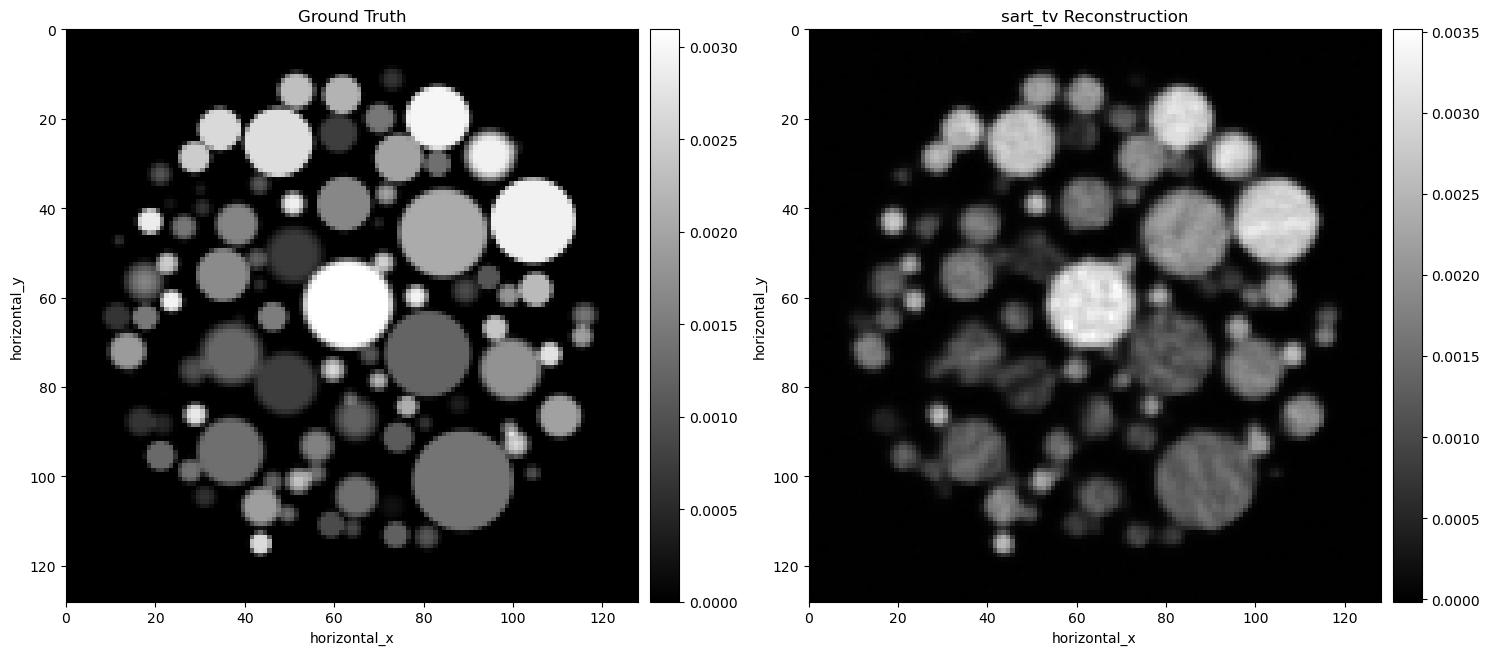

In [52]:
algo = tigre_algo_wrapper(name='sart_tv', tvlambda=50, initial=None, image_geometry=ig, data=absorption, niter=5, gpuids=gpuids)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'sart_tv Reconstruction'], origin = 'upper', num_cols = 2);

/tmp/ipykernel_1386615/2087777472.py:1: UserWarning: We are aware that the TIGRE algorithms: ISTA, FISTA, SART_TV, OSSART_TV using 2D data can lead to incorrect results in the TV denoising step, particularly when using more than one GPU.
  algo = tigre_algo_wrapper(name='ossart_tv', initial=None, image_geometry=ig, data=absorption, niter=5)


OSSART_TV algorithm in progress.
Estimated time until completion : 00:00:02


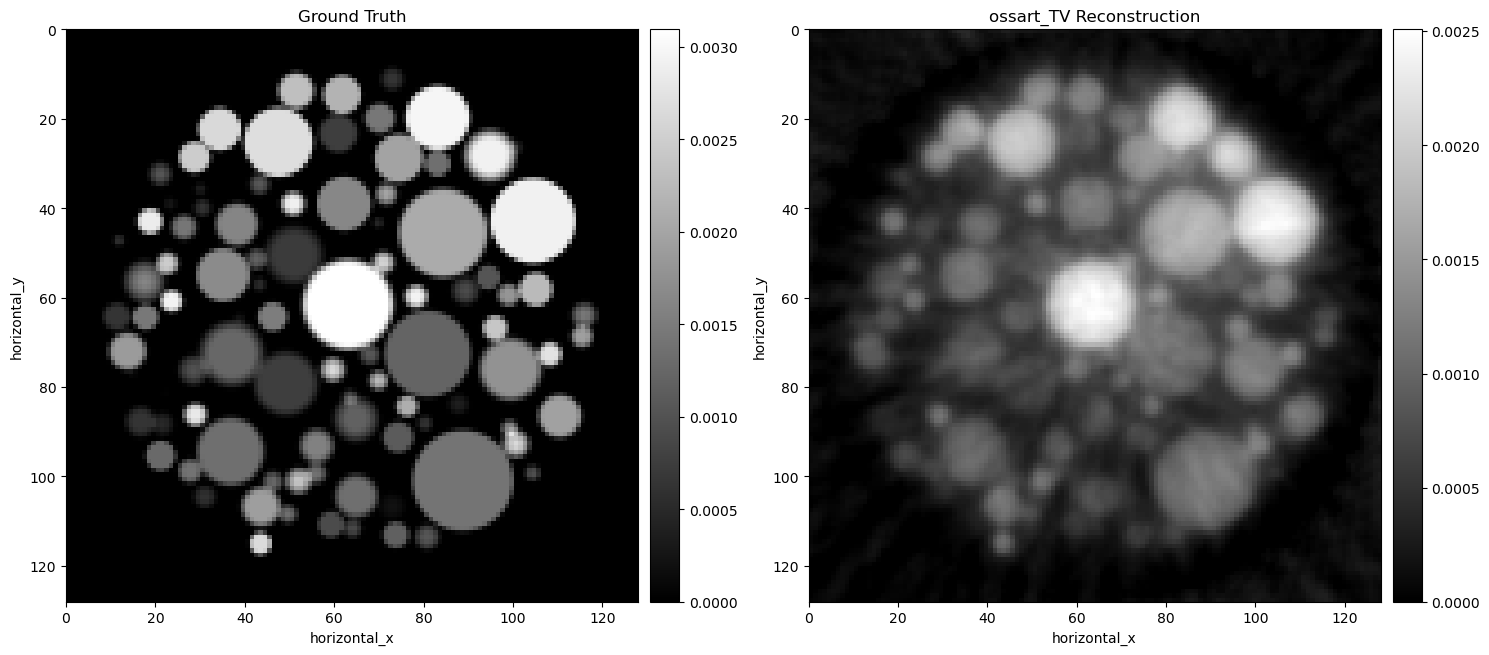

In [53]:
algo = tigre_algo_wrapper(name='ossart_tv', initial=None, image_geometry=ig, data=absorption, niter=5)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'ossart_TV Reconstruction'], origin = 'upper', num_cols = 2);

In [54]:
# 3D Parallel beam 

In [55]:
name= 'fista'
any( a==name for a in ['ista', 'fista', 'sart_tv', 'ossart_tv']) # check if name is in the list

True

New geometry:  3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [0., 0., 0.]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [128 128]
	Pixel size: [16. 16.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 60
	Angles 0-9 in degrees: [ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54.]
	Angles 50-59 in degrees: [300., 306., 312., 318., 324., 330., 336., 342., 348., 354.]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (60, 128, 128)
New geometry shape:  (60, 128, 128)


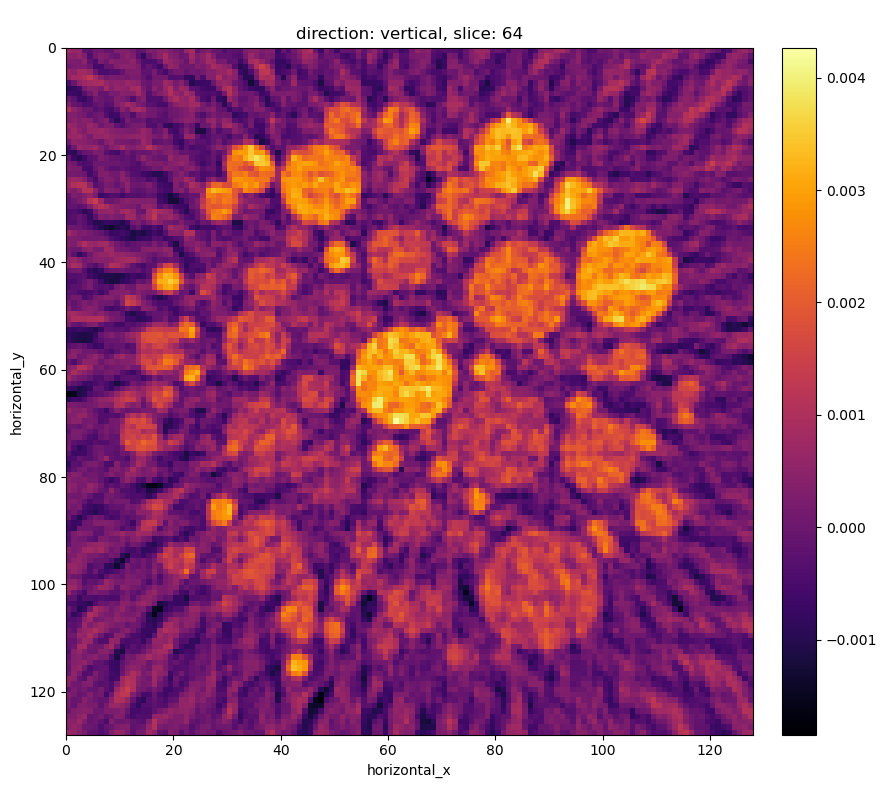

In [56]:

# Load the example data set
from cil.utilities.dataexample import SIMULATED_PARALLEL_BEAM_DATA
data_sync = SIMULATED_PARALLEL_BEAM_DATA.get()

absorption = TransmissionAbsorptionConverter()(data_sync)
# Crop data and reorder for tigre backend
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)
absorption.reorder('tigre')

# Set up and run FBP for 15-angle dataset

recon = FBP(absorption, backend='tigre').run(verbose=0)

ag = absorption.geometry
ig = absorption.geometry.get_ImageGeometry()

show2D(recon,  cmap='inferno', origin='upper-left')


CGLS algorithm in progress.
Estimated time until completion : 00:00:00
Average time taken for each iteration for CGLS:0.01090373150072992(s)


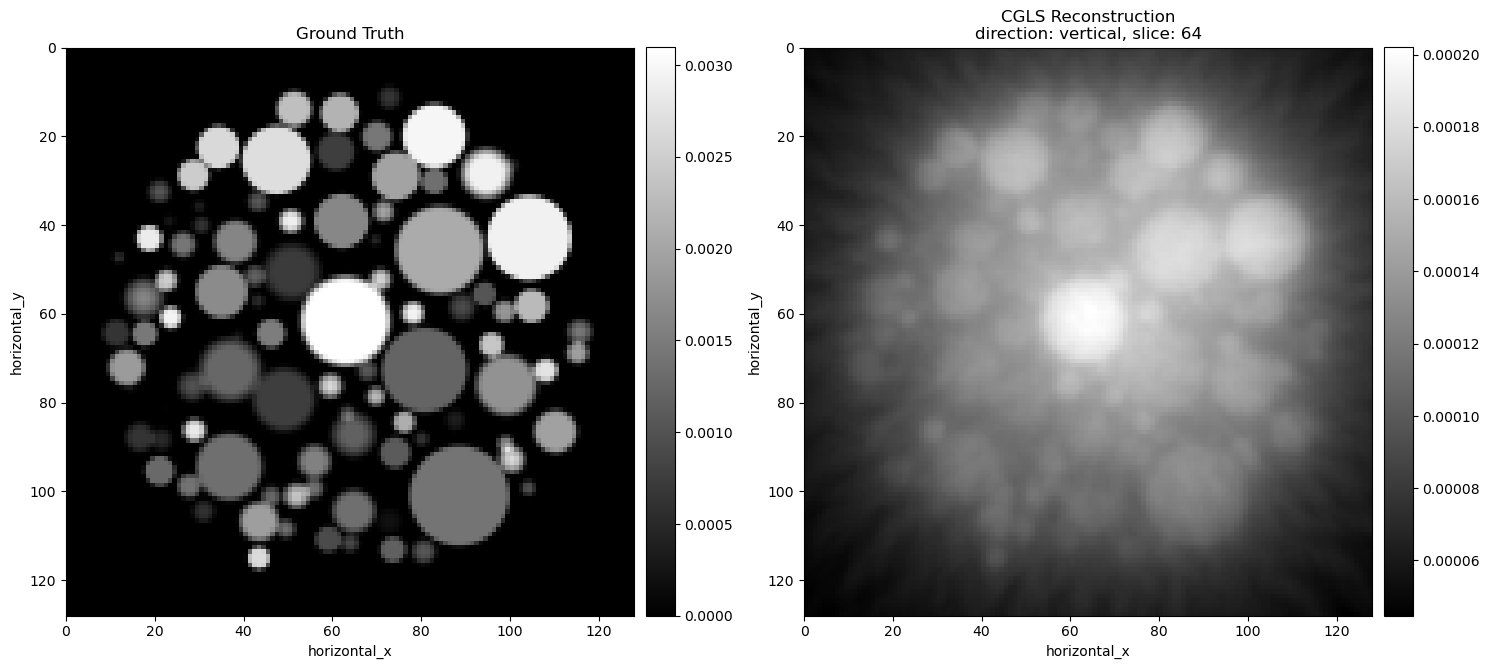

ISTA algorithm in progress.
Estimated time until completion : 00:00:11


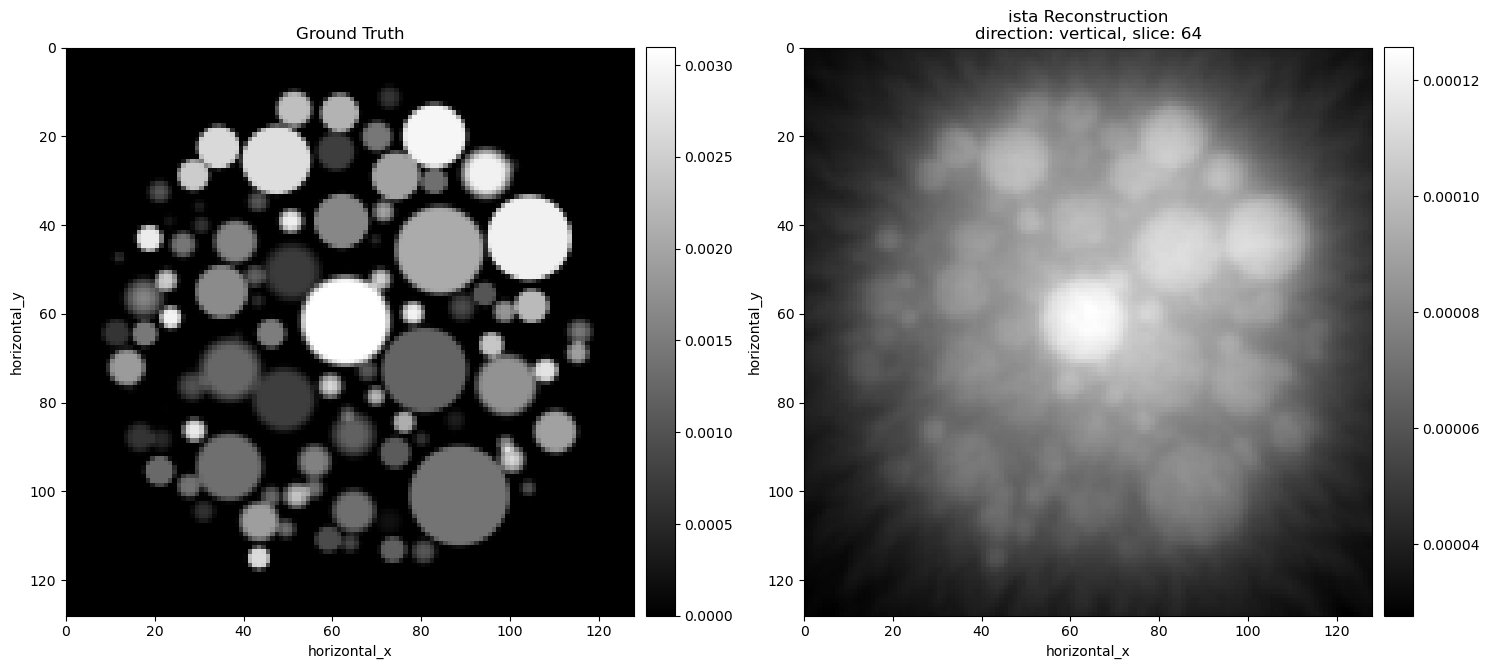

FISTA algorithm in progress.
Estimated time until completion : 00:00:06


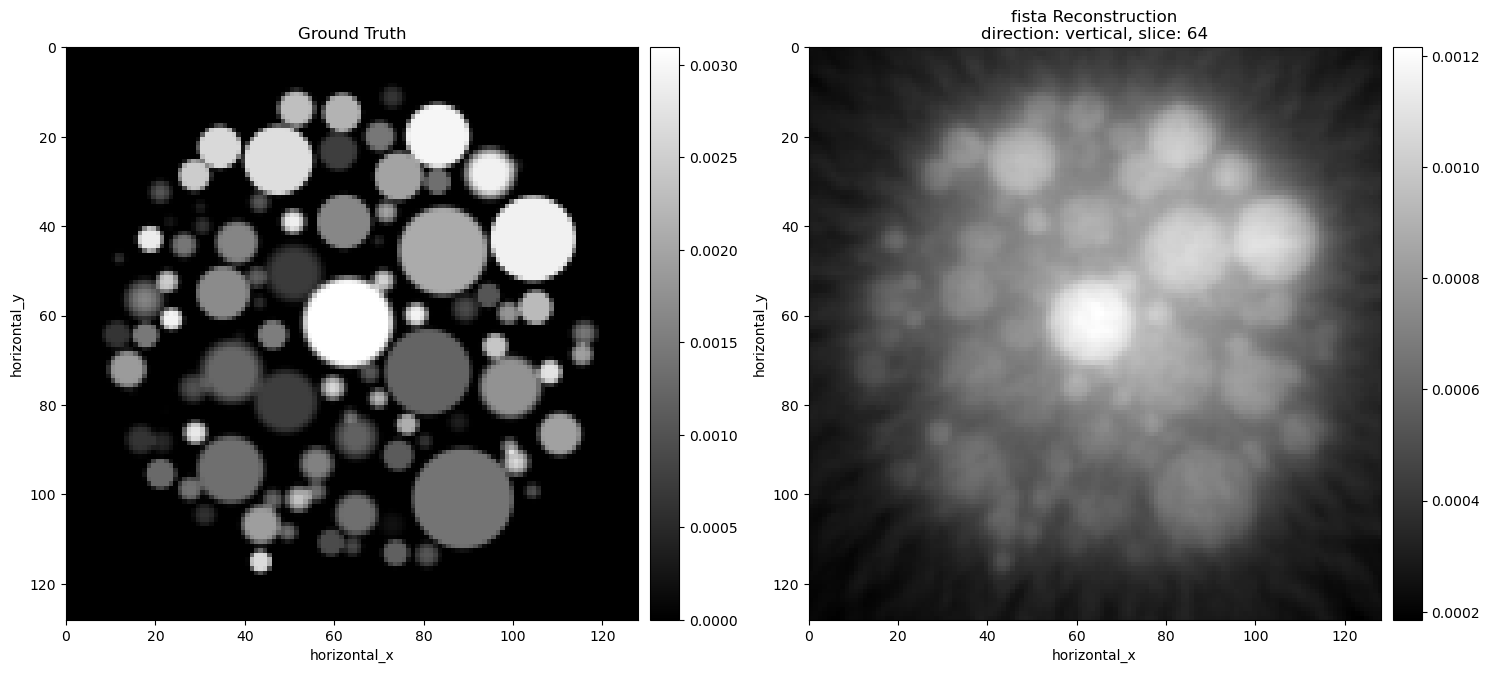

SART_TV algorithm in progress.
Estimated time until completion : 00:00:08


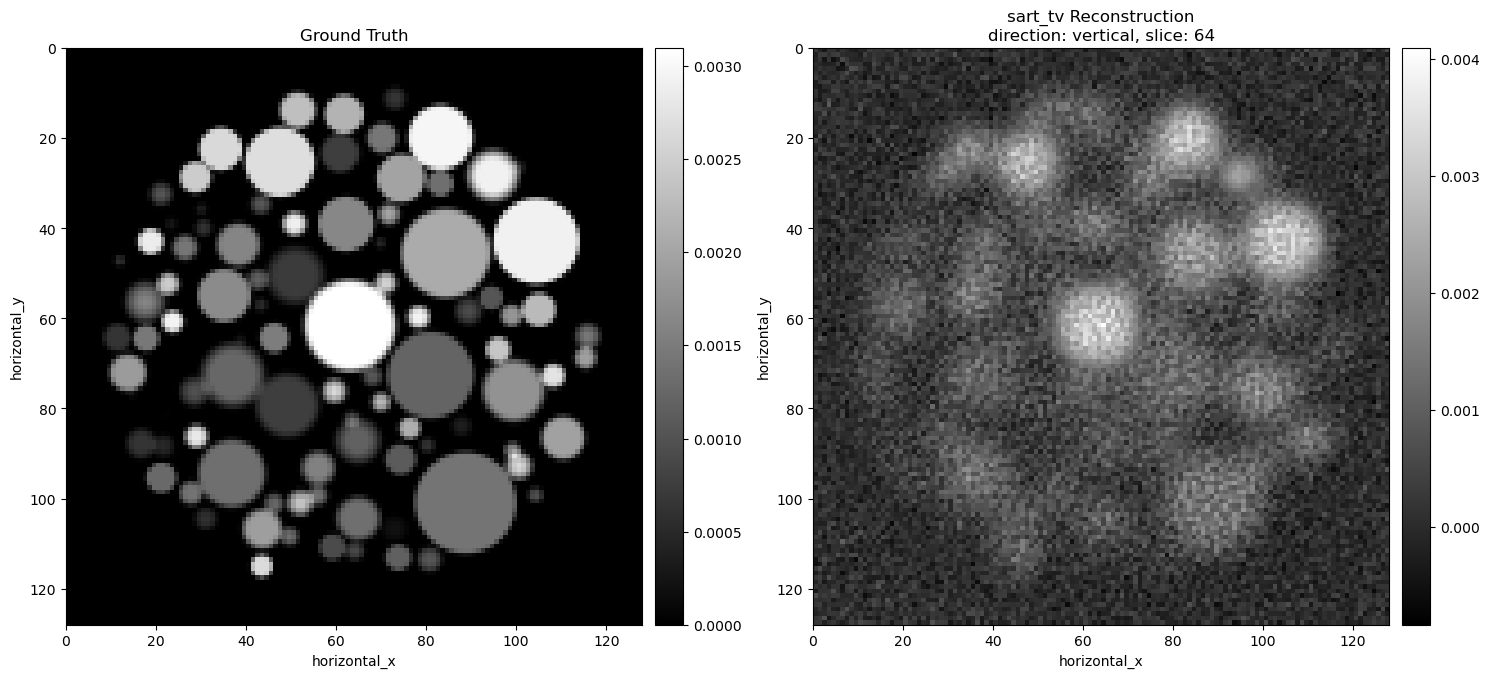

OSSART_TV algorithm in progress.
Estimated time until completion : 00:00:00


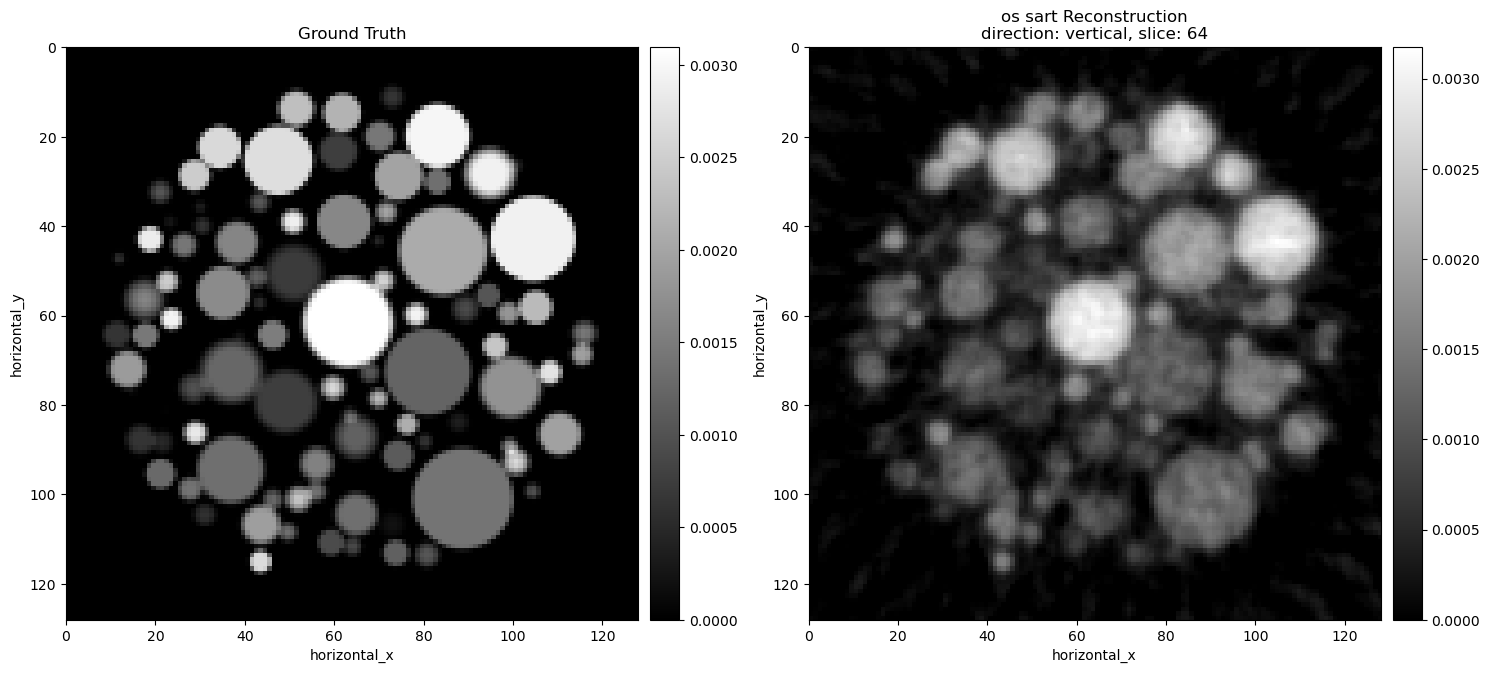

In [57]:
algo = tigre_algo_wrapper(name='cgls', initial=None, image_geometry=ig, data=absorption, niter=10)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'CGLS Reconstruction'], origin = 'upper', num_cols = 2);

algo = tigre_algo_wrapper(name='ista', initial=None, image_geometry=ig, data=absorption, niter=100)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'ista Reconstruction'], origin = 'upper', num_cols = 2);

algo = tigre_algo_wrapper(name='fista', initial=None, image_geometry=ig, data=absorption, niter=100)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'fista Reconstruction'], origin = 'upper', num_cols = 2);

algo = tigre_algo_wrapper(name='sart_tv', tvlambda=2, initial=None, image_geometry=ig, data=absorption, niter=10)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'sart_tv Reconstruction'], origin = 'upper', num_cols = 2)


algo = tigre_algo_wrapper(name='ossart_tv', initial=None, image_geometry=ig, data=absorption, niter=10, tvlambda=0.005)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'os sart Reconstruction'], origin = 'upper', num_cols = 2);

New geometry:  3D Cone-beam tomography
System configuration:
	Source position: [     0., -20000.,      0.]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [    0., 60000.,     0.]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [128 128]
	Pixel size: [64. 64.]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 60
	Angles 0-9 in degrees: [ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54.]
	Angles 50-59 in degrees: [300., 306., 312., 318., 324., 330., 336., 342., 348., 354.]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (60, 128, 128)
New geometry shape:  (60, 128, 128)
FDK recon

Input Data:
	angle: 60
	vertical: 128
	horizontal: 128

Reconstruction Volume:
	vertical: 128
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	

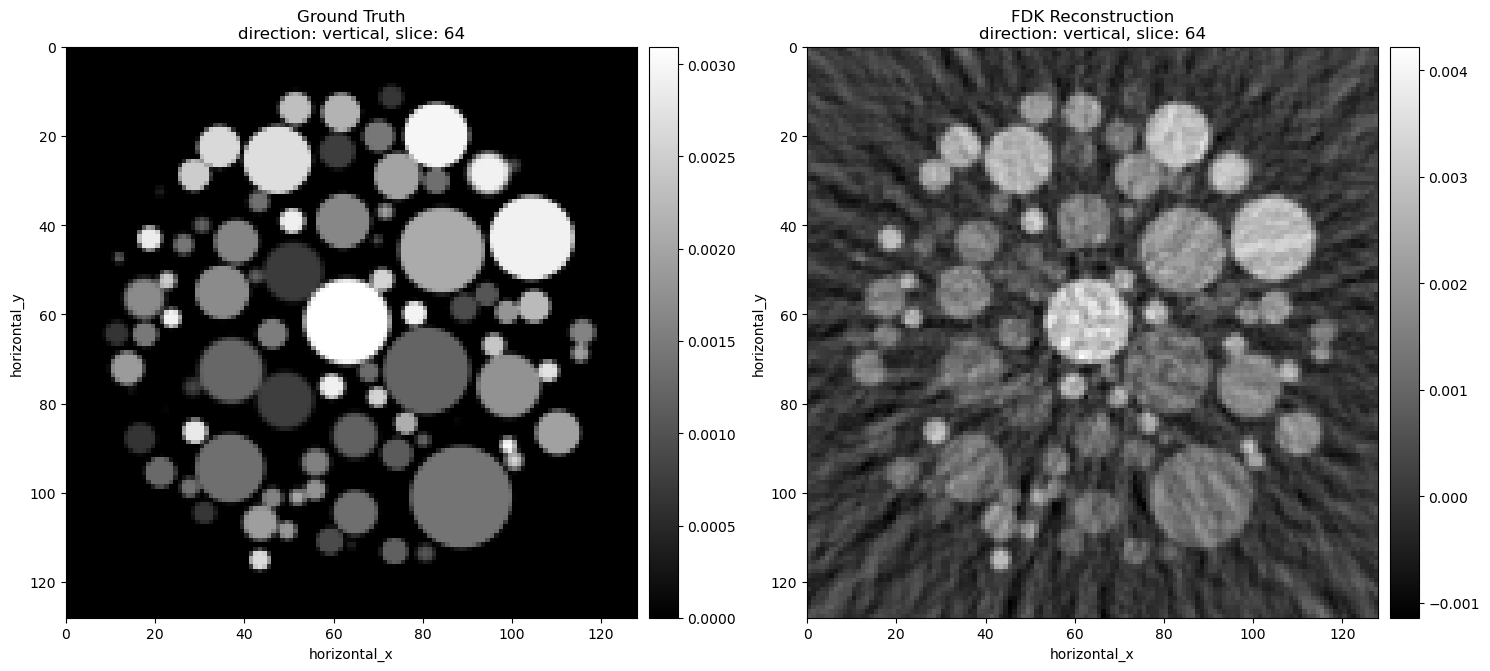

In [58]:
##cone beam data example

ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()


absorption = TransmissionAbsorptionConverter()(data)
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)

ig = ground_truth.geometry

recon = FDK(absorption, image_geometry=ig).run()
show2D([ground_truth, recon], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);
A = ProjectionOperator(ig, absorption.geometry)




CGLS algorithm in progress.
Estimated time until completion : 00:00:02
Average time taken for each iteration for CGLS:0.04067938472144306(s)


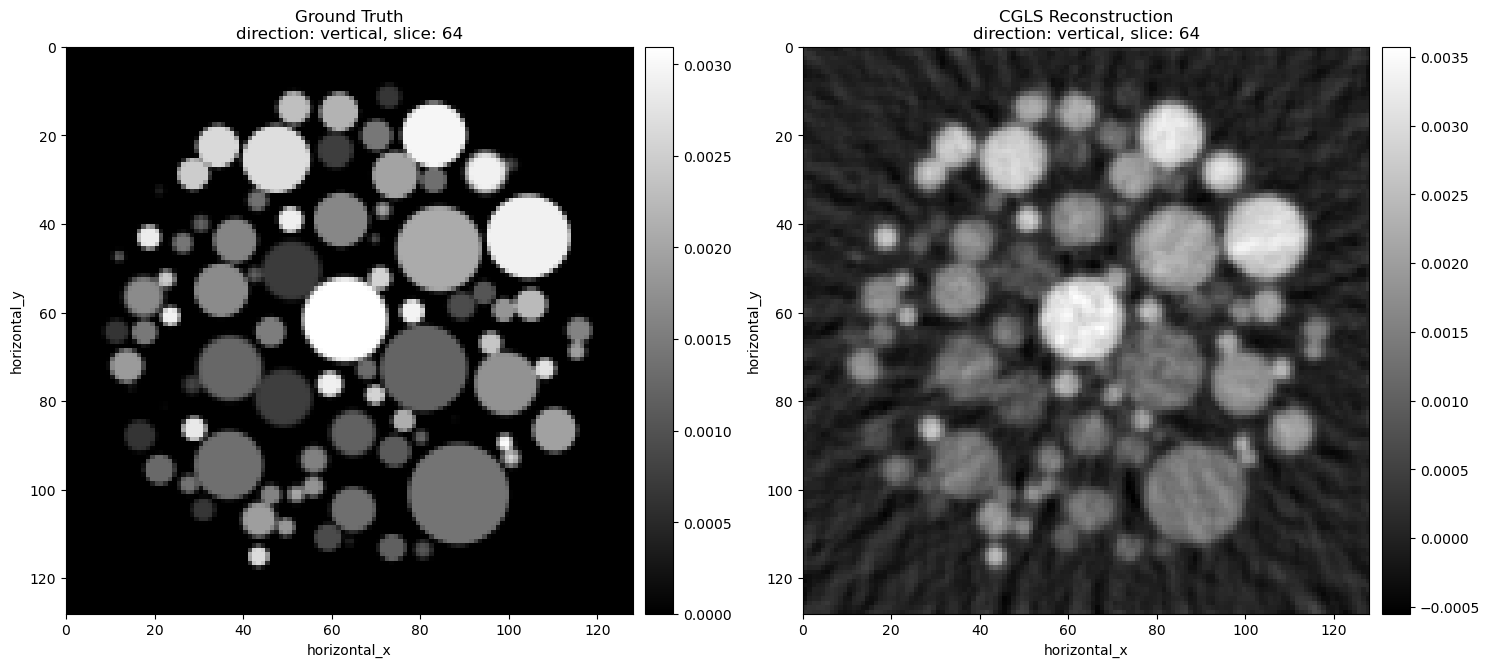

ISTA algorithm in progress.
Estimated time until completion : 00:00:06


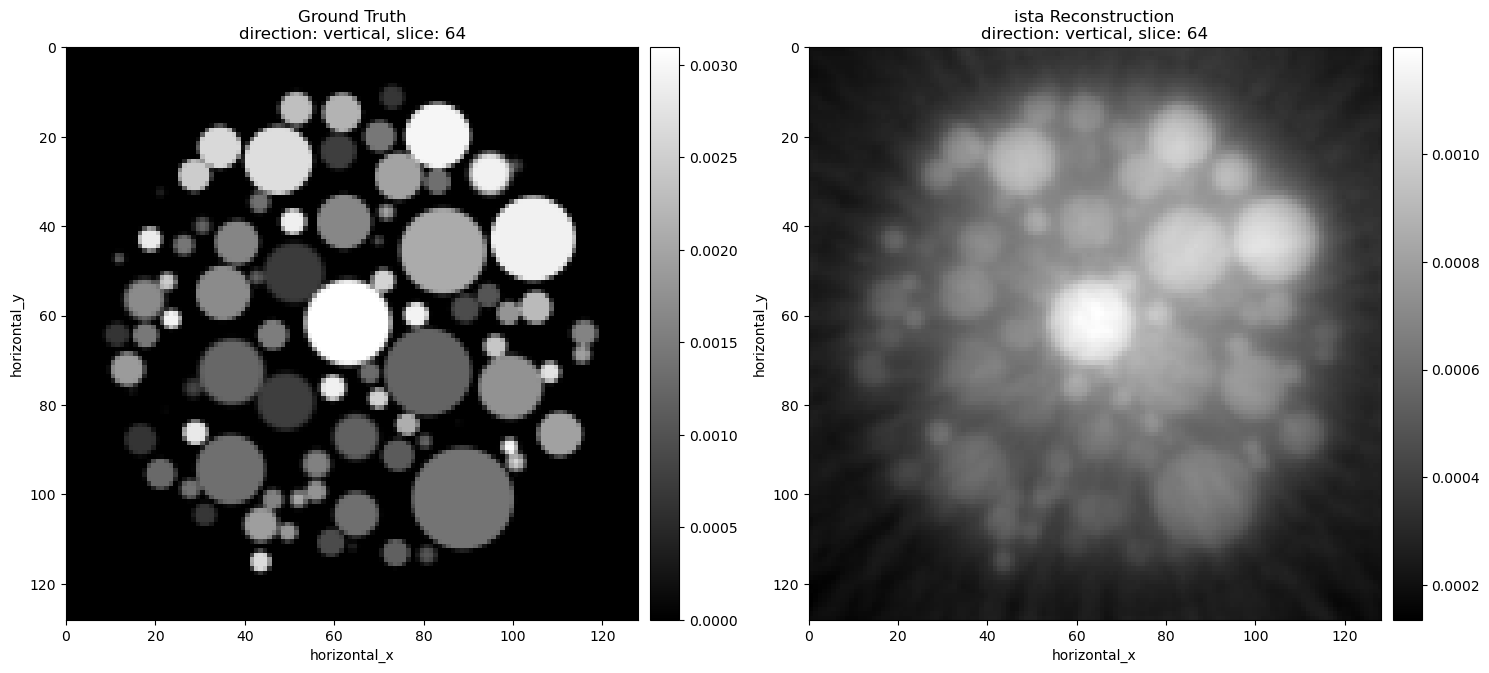

FISTA algorithm in progress.
Estimated time until completion : 00:00:06


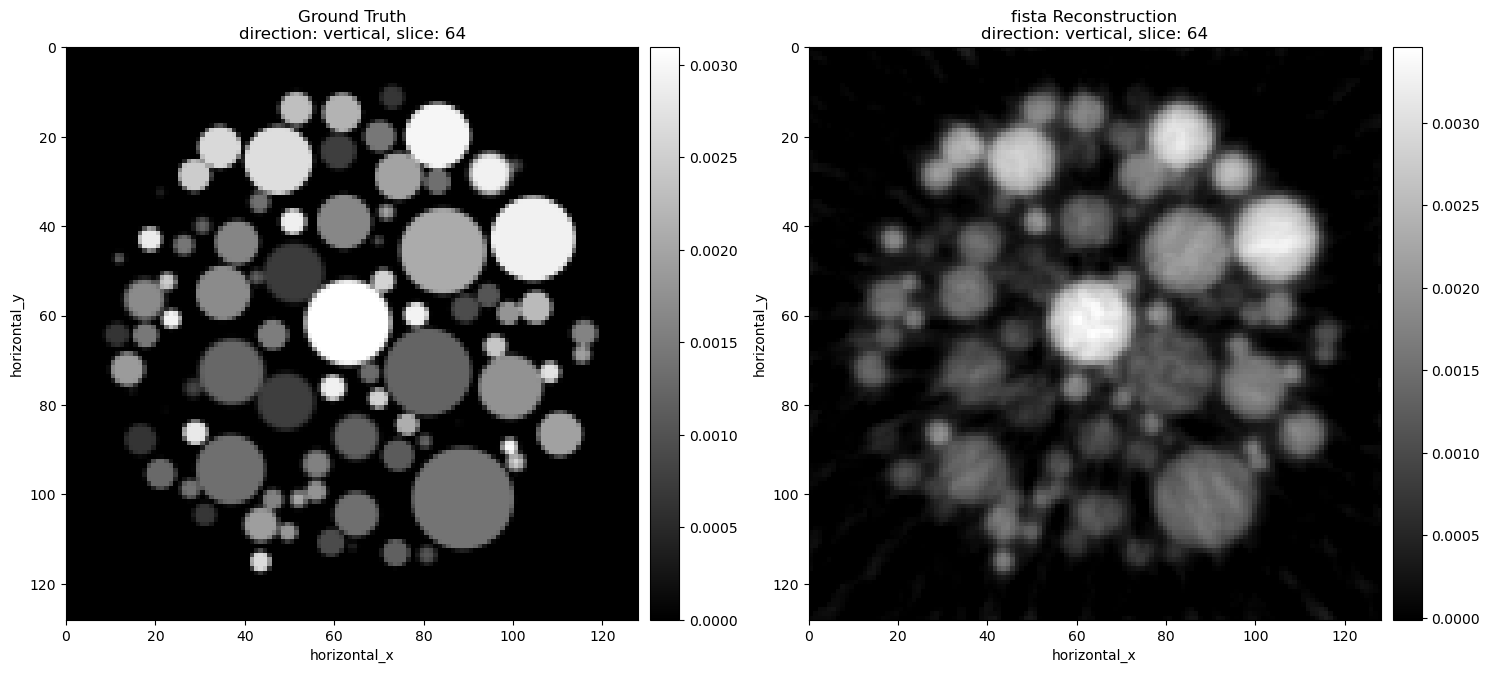

SART_TV algorithm in progress.
Estimated time until completion : 00:02:00


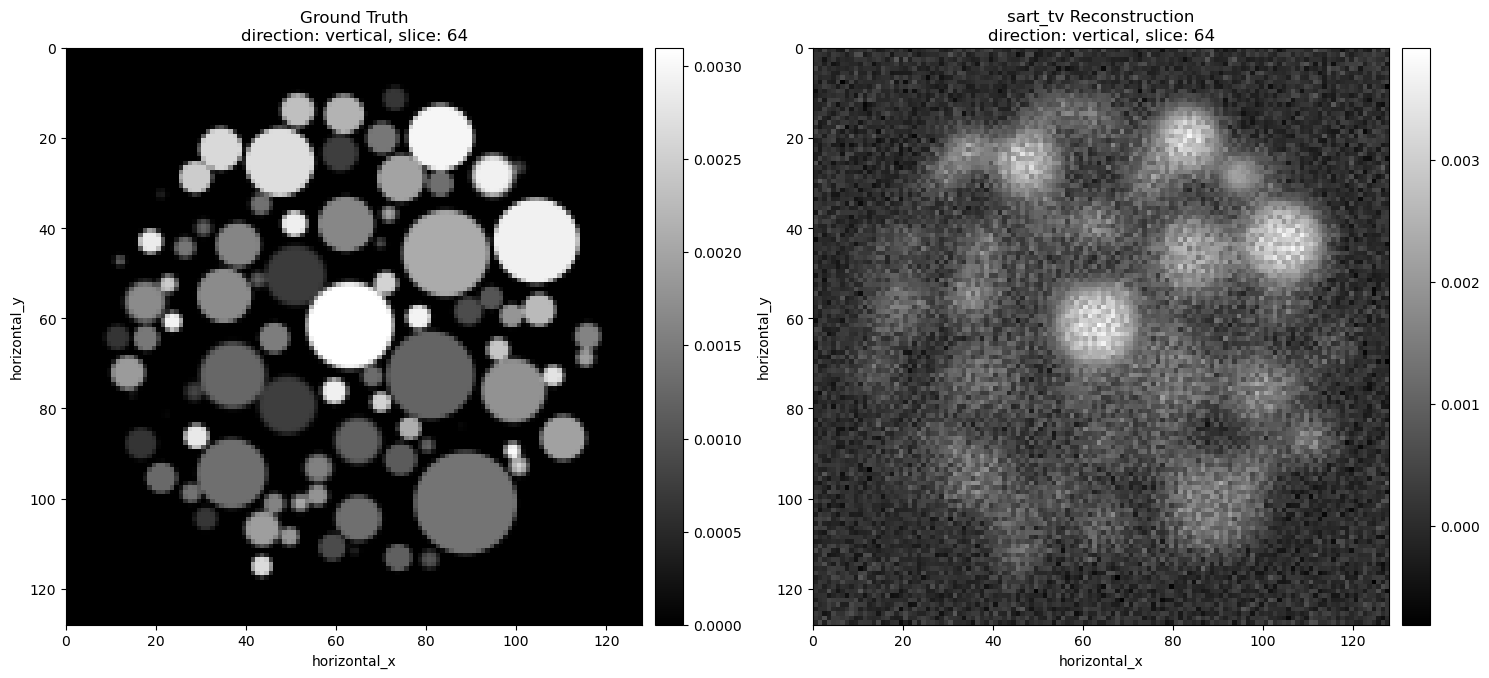

OSSART_TV algorithm in progress.
Estimated time until completion : 00:00:06


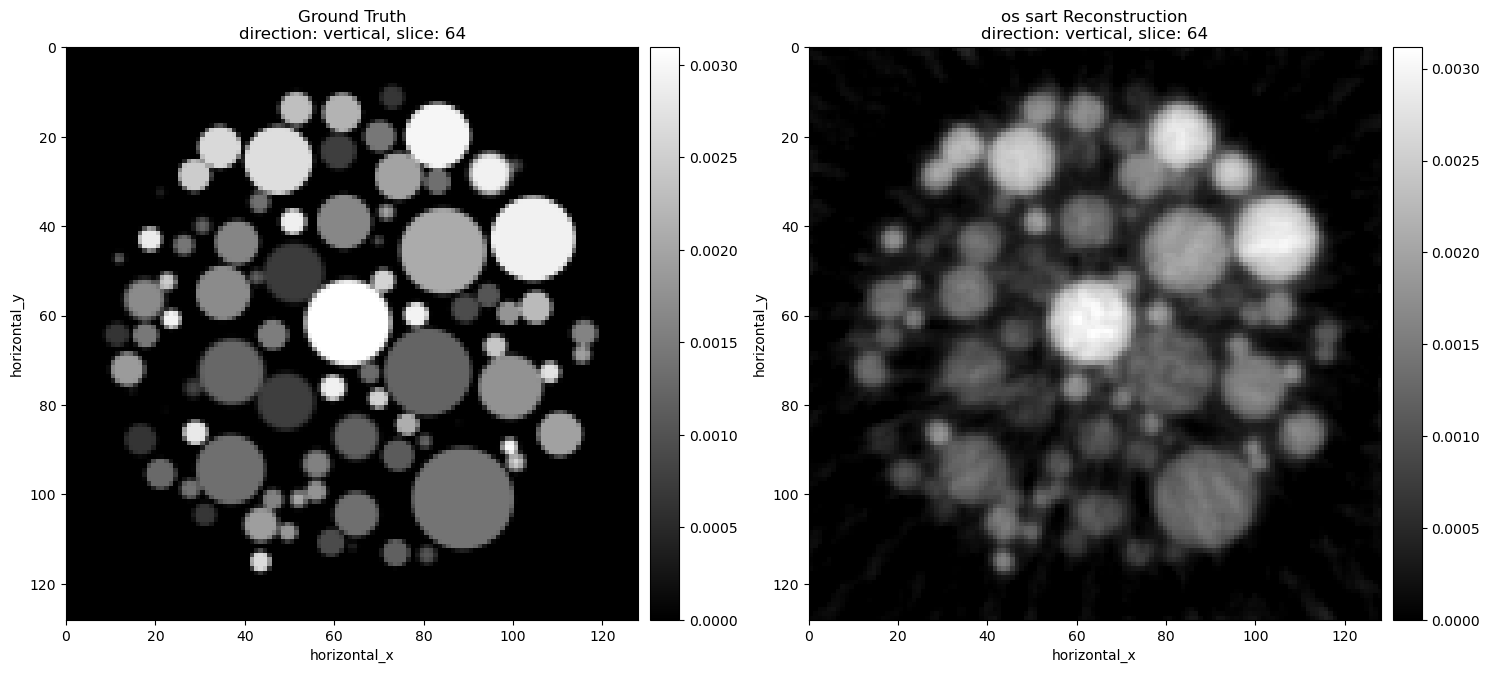

In [59]:
algo = tigre_algo_wrapper(name='cgls', initial=None, image_geometry=ig, data=absorption, niter=10)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'CGLS Reconstruction'], origin = 'upper', num_cols = 2);

algo = tigre_algo_wrapper(name='ista', initial=None, image_geometry=ig, data=absorption, niter=100)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'ista Reconstruction'], origin = 'upper', num_cols = 2);

algo = tigre_algo_wrapper(name='fista', initial=None, image_geometry=ig, data=absorption, niter=100)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'fista Reconstruction'], origin = 'upper', num_cols = 2);

algo = tigre_algo_wrapper(name='sart_tv', tvlambda=2, initial=None, image_geometry=ig, data=absorption, niter=10)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'sart_tv Reconstruction'], origin = 'upper', num_cols = 2)


algo = tigre_algo_wrapper(name='ossart_tv', initial=None, image_geometry=ig, data=absorption, niter=10, tvlambda=0.005)
img, qual = algo.run()
show2D([ground_truth, img], title = ['Ground Truth', 'os sart Reconstruction'], origin = 'upper', num_cols = 2);